<a href="https://colab.research.google.com/github/Amaljayaranga/ContrastiveLoss/blob/master/Contrastive_Accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


Epoch 1  traning loss  0.09046943342631183
Epoch 1  Eval loss  0.08849343171356418
model is saving


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SimaseNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:269: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:270: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Epoch 1  traning accuracy  55.637862042682926  F1 score  0.5563773995352626
Epoch 1  test accuracy  56.05  F1 score  0.5604999604449964
Epoch 2  traning loss  0.08847944805307723
Epoch 2  Eval loss  0.08908231754569297
model is saving
Epoch 2  traning accuracy  55.752191310975604  F1 score  0.5575230896912735
Epoch 2  test accuracy  56.07  F1 score  0.5606933181453689
Epoch 3  traning loss  0.08828047438093074
Epoch 3  Eval loss  0.08834194251937223
model is saving
Epoch 3  traning accuracy  55.71408155487805  F1 score  0.557139366612478
Epoch 3  test accuracy  56.44  F1 score  0.5643907825089578
Epoch 4  traning loss  0.08868738083259725
Epoch 4  Eval loss  0.08876292750979146
model is saving
Epoch 4  traning accuracy  55.5640243902439  F1 score  0.5556495777583023
Epoch 4  test accuracy  55.769999999999996  F1 score  0.5576999601929963
Epoch 5  traning loss  0.08842319238749219
Epoch 5  Eval loss  0.08825417652937538
model is saving
Epoch 5  traning accuracy  55.76171875  F1 score  0

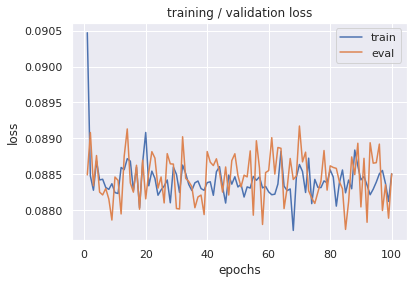

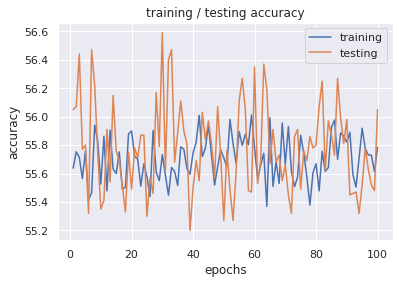

In [10]:
from argparse import ArgumentParser
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns;sns.set()
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from torchvision.datasets import MNIST
from sklearn.metrics import f1_score
from PIL import Image

parser = ArgumentParser(description='Simase Network')
parser.add_argument('--batch_size', type=int, default=64)
parser.add_argument('--constractive_loss_margin', type=float, default=0.8)
parser.add_argument('--learning_rate', type=float, default=1e-3)
parser.add_argument('--num_epochs', type=int, default=100)
parser.add_argument('--weight_decay', type=float, default=1e-5)
parser.add_argument('--validation_split', type=float, default=0.3)
parser.add_argument('--mode', type=str, default='train')
parser.add_argument('--device', type=str, default='cuda')

args, unknown = parser.parse_known_args()

DEVICE = args.device
if not torch.cuda.is_available():
    DEVICE = 'cpu'

class SimaseNet(nn.Module):

    def __init__(self):
        super(SimaseNet, self).__init__()

        self.conv = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2, stride=2),
                                  nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2, stride=2)
                                  )
        # output 64,4,4
        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 256),
                                nn.ReLU(),
                                nn.Linear(256, 256),
                                nn.ReLU(),
                                nn.Linear(256, 16)
                                )

    def forward_once(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x

    def forward(self, in1, in2):
        out1 = self.forward_once(in1)
        out2 = self.forward_once(in2)
        return out1, out2


class SiameseMNIST(Dataset):

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}

        else:
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                               1]
                              for i in range(0, len(self.test_data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.test_labels[i].item()]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.test_data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, index):

        if self.train:
            target = np.random.randint(0, 2)  # 0,1
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            if target == 1:  # similar ones
                siamese_index = index
                while siamese_index == index:
                    siamese_index = np.random.choice(self.label_to_indices[label1])  # Random

            else:
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.train_data[siamese_index]

        else:
            img1 = self.test_data[self.test_pairs[index][0]]
            img2 = self.test_data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]

        img1 = Image.fromarray(img1.numpy())
        img2 = Image.fromarray(img2.numpy())

        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, target


class ContrastiveLoss(nn.Module):

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output, target):
        eq_distance = F.pairwise_distance(output[0], output[1])
        loss = 0.5 * (1 - target.float()) * torch.pow(eq_distance, 2) + \
               0.5 * target.float() * torch.pow(torch.clamp(self.margin - eq_distance, min=0.00), 2)

        return loss.mean()


train_dataset = MNIST('../data/MNIST', train=True, download=True,
                      transform=transforms.Compose([
                          transforms.ToTensor()
                      ]))

test_dataset = MNIST('../data/MNIST', train=False, download=True,
                     transform=transforms.Compose([
                         transforms.ToTensor()
                     ]))

siamese_train_dataset = SiameseMNIST(train_dataset)
split = int(np.floor(args.validation_split * len(siamese_train_dataset)))
indices = list(range(len(siamese_train_dataset)))
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=args.batch_size,
                                                   sampler=train_sampler, drop_last=True)
siamese_val_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=args.batch_size,
                                                 sampler=valid_sampler)

simase_test_dataset = SiameseMNIST(test_dataset)
siamese_test_loader = torch.utils.data.DataLoader(simase_test_dataset, batch_size=args.batch_size, shuffle=True)


model = SimaseNet()
criterion = ContrastiveLoss(margin=args.constractive_loss_margin)
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

def draw_loss_plot(training_losses, validation_losses, epochs):
    plt.plot(epochs, training_losses, label="train")
    plt.plot(epochs, validation_losses, label="eval")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('training / validation loss')
    plt.legend()
    plt.show()

def draw_accuracy_plot(training_accuracy, testing_accuracy, epochs):
    plt.plot(epochs, training_accuracy, label="training")
    plt.plot(epochs, testing_accuracy, label="testing")
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title('training / testing accuracy')
    plt.legend()
    plt.show()

model = model.to(DEVICE)

train_losses = []
eval_losses = []
epochs = []

train_accuracy = []
test_accuracy = []

chunk = 100

for epoch in range(1, args.num_epochs + 1):

    epochs.append(epoch)
    
    for dataloader in [siamese_train_loader, siamese_val_loader]:
      losses = []

      if dataloader == siamese_train_loader:
        model.train()
      else:
        model.eval()

      for batch in dataloader:

        img1, img2, target = batch
        img1 = img1.to(DEVICE)
        img2 = img2.to(DEVICE)
        target = target.to(DEVICE)
        out1, out2 = model(img1, img2)
        out1 = out1.to(DEVICE)
        out2 = out2.to(DEVICE)
        out = [out1, out2]
        loss = criterion(out, target)

        if dataloader == siamese_train_loader:
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

        #if batch_idx % chunk == 0:
            #print("Epoch : ", epoch, "Batch : ", batch_idx, "loss : ", loss.item())

        losses.append(loss.item())

      if dataloader == siamese_train_loader:
        train_losses.append(np.mean(losses))
        print("Epoch", epoch, " traning loss ", np.mean(losses))
      else:
        eval_losses.append(np.mean(losses))
        print("Epoch", epoch, " Eval loss ", np.mean(losses))
 
    torch.save(model, '1.pth')
    print('model is saving')
  
    model = torch.load('1.pth')
    model = model.to(DEVICE)
    model.eval()

    for dataloader in [siamese_train_loader, siamese_test_loader]:
       
        predict_np = np.array([])
        target_np = np.array([])

        for batch in dataloader:
            img1, img2, target = batch
            img1 = img1.to(DEVICE)
            img2 = img2.to(DEVICE)

            out1, out2 = model(img1, img2)

            eq_distance = F.pairwise_distance(out1.cpu(), out2.cpu()).detach().numpy()

            similar_distances = eq_distance[[np.where(target == 1)]]
            dissimilar_distances = eq_distance[[np.where(target == 0)]]

            center_similar = np.median(similar_distances)
            center_dissimilar = np.median(dissimilar_distances)
                                             
            # true means they are dissimilair pair
            predict_np = np.append(predict_np, np.invert(
                np.logical_and((np.abs(eq_distance - center_similar) > np.abs(eq_distance - center_dissimilar)), True)))
            target_np = np.append(target_np, target)

        acc = np.subtract(target_np, predict_np)
        accuracy = ((acc == 0).sum() / acc.size) * 100
        f1 = f1_score(target_np, predict_np, average='weighted')

        if dataloader == siamese_train_loader:
          train_accuracy.append(accuracy)
          print("Epoch", epoch, " traning accuracy ", accuracy ," F1 score ", f1)
        else:
          test_accuracy.append(accuracy)
          print("Epoch", epoch, " test accuracy ", accuracy," F1 score ", f1)


draw_loss_plot(train_losses,eval_losses,epochs)
draw_accuracy_plot(train_accuracy,test_accuracy,epochs)




















